# Machine Learning Assignment
Στο συγγεκριμένο notebook βρίσκονται οι ασκήσεις του μαθήματος "Μηχανική Μάθηση" της χρονιάς 2024-2025.

Το dataset που χρησιμοποίησα είναι το Wine Quality Dataset του πανεπιστημίου UC Irvine (https://archive.ics.uci.edu/dataset/186/wine+quality). Πρόκειται για ένα dataset με 11 features και 1 label, την ποιότητα του κρασιού, που είναι ένα σκορ από 0 εώς 10. Για τους σκοπούς της άσκησης, θα υποθέσουμε ότι το κάθε σκορ μπορεί να ανήκει σε μία από 5 κατηγορίες:

*   Κάκιστο (Very Bad. Score: 0-2)
*   Κακό (Bad. Score: 2-4)
*   Εντάξει (Alright. Score 4-6)
*   Καλό (Good. Score 6-8)
*   Άριστο (Excellent. Score 8-10)

Τα ερωτήματα είναι τεράστια για ένα notebook, οπότε αποφάσισα να τα χωρίσω ανά 2. Το συγκεκριμένο notebook θα έχει τα παρακάτω ερωτήματα:

3.   Logistic Regression
4.   K Nearest Neighbors (KNN)

Στα υπόλοιπα αρχεία θα λυθούν τα θέματα με την ακόλουθη σειρά:

5.   Naive Bayes
6.   Multilayer Perceptron (MLP) in Pytorch
7.   Support Vector Machine (SVM)
8.   K Means

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/MLAssignment/Data')

Mounted at /content/drive


# Data Preprocessing

In [ ]:
wines = pd.read_csv('winequality-red.csv', sep=';')

features = wines.drop("quality", axis=1)
label = wines["quality"]

X = np.array(features)
y = wines[["quality"]].to_numpy() #For shape (n,1)

# I am aware this method is not good for edge cases, but it is what it is

# Changed the classification from string to int in order do do one-hot vectors easier later

def classify(y):
    if y < 2.0:
        y = 0
    elif y < 4.0:
        y = 1
    elif y < 6.0:
        y = 2
    elif y < 8.0:
        y = 3
    else:
        y = 4
    return y

y_classified = np.array([classify(label) for label in y])

y_one_hot = np.eye(y_classified.max() + 1)[y_classified] #transform the label to a one-hot vector

In [ ]:
def normalize_features(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    return X_normalized

X_normalized = normalize_features(X)

# 3) Logistic Regression

In [ ]:
# We will be using softmax since we are dealing with multi classification

def softmax( x, ax=1 ):
    m = np.max( x, axis=ax, keepdims=True )#max per row
    #m = np.zeros_like(x)
    p = np.exp( x - m )
    return p / np.sum(p,axis=ax,keepdims=True)

In [ ]:
def ComputeCostGrad( X, y, theta, _lambda ):

    h = softmax( X.dot(theta) )#hypothesis h_theta

    #calc cost function (Cross Entropy Loss)
    cur_j = -np.sum(y * np.log(h)) / X.shape[0]

    #calculate gradient
    reg = _lambda * theta
    grad = - ( X.T.dot( y - h ) ) + reg

    return cur_j, grad

In [ ]:
def ComputeLogisticRegression( X, y, X_val, y_val, _lambda=0.0, tot_iter=5000, alpha=0.0001 ):

    theta = np.zeros((X.shape[1], y.shape[1]))

    m, n = X.shape

    J_train = []
    J_test = []

    for i in range( tot_iter ):

        train_error, train_grad = ComputeCostGrad( X, y, theta, _lambda )
        test_error, _ = ComputeCostGrad( X_val, y_val, theta, _lambda )

        #update parameters by subtracting gradient values
        theta -= alpha * train_grad

        #print( train_error )
        #store current cost
        J_train.append( train_error )
        J_test.append( test_error )

    return J_train, J_test, theta

In [ ]:
def predict(theta, X):
    #PREDICT Predict whether the label is either of our classes
    #regression parameters theta
    #   p = PREDICT(theta, X) computes the predictions for X

    p = softmax( np.dot(X,theta) )
    prob = p.max()
    p = p.argmax(axis=1)

    return p, prob

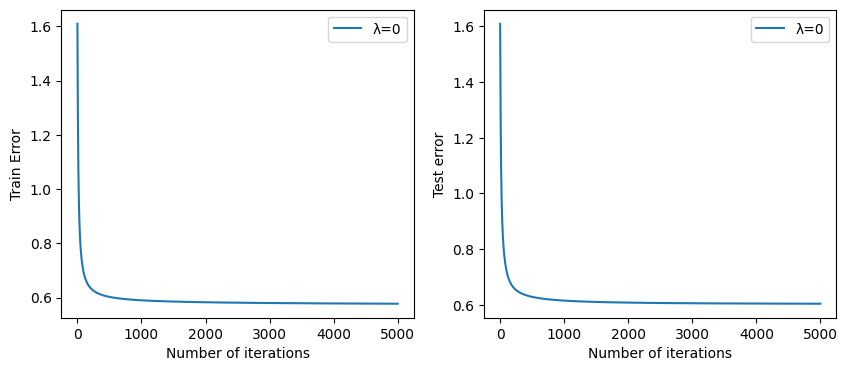

Accuracy of training set 0.7408400357462019
Accuracy of testing set 0.71875


In [ ]:
# Add a bias (intercept) term to the feature matrix
X_normalized = np.concatenate((np.ones((X_normalized.shape[0], 1)), X_normalized), axis=1)

X_train, X_test, y_train, y_test = train_test_split( X_normalized, y_one_hot, test_size=0.3, random_state=42)

J_train, J_test, theta = ComputeLogisticRegression( X_train, y_train, X_test, y_test, _lambda=0.0 )

plt.figure( figsize=(10,4) )
plt.subplot( 1, 2, 1 )
plt.plot( np.arange( len(J_train) ), J_train, label='λ=0' )
plt.xlabel( 'Number of iterations' )
plt.ylabel( 'Train Error' )
plt.legend()
plt.subplot( 1,2,2)
plt.plot( np.arange( len(J_test) ), J_test, label='λ=0' )
plt.xlabel( 'Number of iterations' )
plt.ylabel( 'Test error' )
plt.legend()
plt.show()
p_train, prob_train = predict( theta, X_train )
p_test, prob_test = predict( theta, X_test )

y_train_labels = y_train.argmax(axis=1) #transform y_train back to labels
y_test_labels = y_test.argmax(axis=1) #transform y_test back to labels

print( 'Accuracy of training set', np.mean( p_train.astype('int') == y_train_labels ) )
print( 'Accuracy of testing set', np.mean( p_test.astype('int') == y_test_labels ) )

#4) K Nearest Neighbors (KNN)

In [ ]:
def sqrdist(x, y):
    y = np.tile(y,(x.shape[0],1))
    d = np.sqrt((np.square(x-y).sum(axis=1)))
    return d

In [ ]:
def knn_test(X, T, Xtest, K):
    Ntest = Xtest.shape[0]
    Ttest = np.zeros((Ntest, 5))
    for n in range(Ntest):
        d = sqrdist(X, Xtest[n,:])
        # return the indices of the K closest instances
        closest = np.argsort(d)[:K]
        # get the predicted values of the closest instances
        Tclosed = T[closest,:] # shape = kx5
        votes = Tclosed.sum(axis=0) #shape = 5x1
        Ttest[n, np.argmax(votes)] = 1
    return Ttest

In [ ]:
def cross_validation(K, numFolds, X, T):
    """
    """
    N = X.shape[0]
    #random permute the data before we split them
    np.random.seed(10)
    perm = np.random.permutation(N)
    X = X[perm]
    T = T[perm]
    # The fold variable will have size numFolds + 1
    chunk_size = int(N/numFolds)
    split_ind = np.arange(chunk_size,chunk_size*numFolds, chunk_size)

    Xfolds = np.vsplit(X, split_ind) # list of arrays
    Tfolds = np.vsplit(T, split_ind)
    valerr = np.zeros((K, numFolds))

    for k in range(1, K+1):
        for j in range(numFolds):
            X_train = np.vstack([Xfolds[i] for i in range(len(Xfolds)) if i != j])
            y_train = np.vstack([Tfolds[i] for i in range(len(Tfolds)) if i != j])
            X_test = Xfolds[j]
            # prediction using kNN
            Ttest = knn_test(X_train, y_train, X_test, k)

            Tval = np.argmax(Ttest, axis=1)
            Tcor = np.argmax(Tfolds[j], axis=1)
            valerr[k-1, j] = np.count_nonzero(Tval!=Tcor)/X_test.shape[0]
            print("kNN for k = {}, fold # {}, error = {} ".format(k, j, valerr[k-1, j]))
    # average the validation errors
    val = valerr.sum(axis=1)/numFolds
    # select best k
    kbest = np.argmin(val)+1
    # Plot the evolution of the validation error with respect to k
    plt.plot(range(1, K+1), val*100)
    plt.ylabel('Average Validation Error %')
    plt.xlabel('K Nearest Neighbors')
    plt.show()
    print("Best k is {} with average error = {} ".format(kbest, val[kbest-1]))
    return kbest

kNN for k = 1, fold # 0, error = 0.3333333333333333 
kNN for k = 1, fold # 1, error = 0.15315315315315314 
kNN for k = 1, fold # 2, error = 0.24324324324324326 
kNN for k = 1, fold # 3, error = 0.25225225225225223 
kNN for k = 1, fold # 4, error = 0.3063063063063063 
kNN for k = 1, fold # 5, error = 0.34234234234234234 
kNN for k = 1, fold # 6, error = 0.3063063063063063 
kNN for k = 1, fold # 7, error = 0.2702702702702703 
kNN for k = 1, fold # 8, error = 0.3153153153153153 
kNN for k = 1, fold # 9, error = 0.2833333333333333 
kNN for k = 2, fold # 0, error = 0.34234234234234234 
kNN for k = 2, fold # 1, error = 0.21621621621621623 
kNN for k = 2, fold # 2, error = 0.3333333333333333 
kNN for k = 2, fold # 3, error = 0.2882882882882883 
kNN for k = 2, fold # 4, error = 0.25225225225225223 
kNN for k = 2, fold # 5, error = 0.38738738738738737 
kNN for k = 2, fold # 6, error = 0.34234234234234234 
kNN for k = 2, fold # 7, error = 0.2972972972972973 
kNN for k = 2, fold # 8, error = 0.44

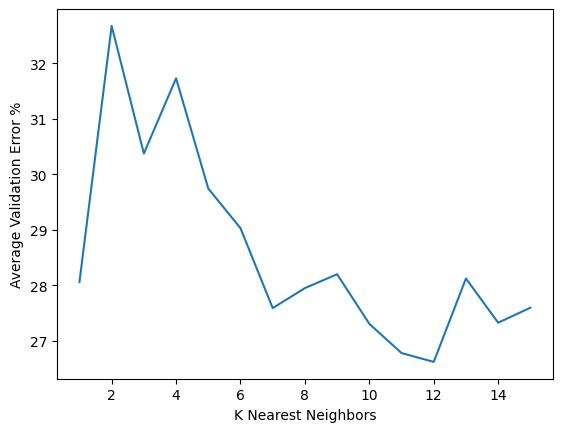

Best k is 12 with average error = 0.2661711711711712 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X_normalized, y_one_hot, test_size=0.3, random_state=42)
kbest = cross_validation(15, 10, X_train, y_train)